# VBLL Regression 

In this notebook, we will walk through implementing a simple VBLL regression model. We will first set up a basic training loop on toy data, and show the model changes required to train a model with a VBLL last layer. Finally, we will show how VBLL models can be combined with other uncertainty quantification ideas.

In [ ]:
!pip install numpyro[cuda] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


In [1]:
# Install vbll
# !pip install vbll
import vbll

# Import necessary packages
import numpy as np
from dataclasses import dataclass
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from copy import deepcopy
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training import train_state
import optax
from jax.scipy.linalg import cholesky, inv, solve, solve_triangular
import numpyro
import warnings

/Users/conor/miniconda3/envs/pymc_data_augmentation/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
vbll.layers


AttributeError: module 'vbll' has no attribute 'jax'

First we will define and visualize a simple dataset.

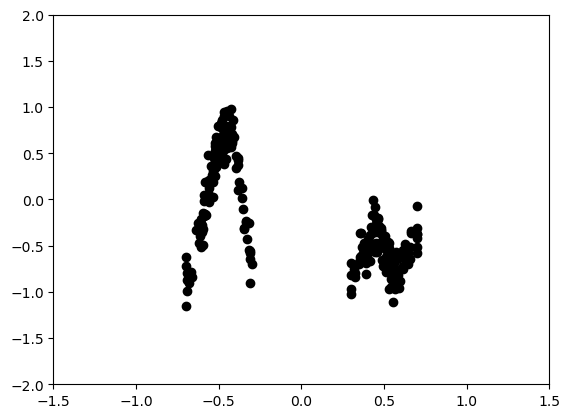

In [16]:
class SimpleFnDataset(Dataset):
    """
    CONOR: Adapted from the "VBLL_Regression.ipynb" example on the original repository
    The simple function used in DUE/SNGP 1-d regression experiments.
    Based on the implementation presented in:
    https://github.com/y0ast/DUE/blob/main/toy_regression.ipynb
    """

    def __init__(self, num_samples):
        self.num_samples = int(num_samples)
        self.X, self.Y = self.get_data()

    def get_data(self, noise=0.15, seed=2):
        np.random.seed(seed)

        W = np.random.randn(30, 1)
        b = np.random.rand(30, 1) * 2 * np.pi

        x = 5 * np.sign(np.random.randn(self.num_samples)) + np.random.randn(self.num_samples).clip(-2, 2)
        y = np.cos(W * x + b).sum(0)/5. + noise * np.random.randn(self.num_samples)
        return x[:, np.newaxis]/10, y[:, np.newaxis]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

def viz_data(dataset):
    plt.scatter(dataset.X, dataset.Y, color='k')
    plt.axis([-1.5, 1.5, -2, 2])
    plt.show()

dataset = SimpleFnDataset(num_samples=256)

viz_data(dataset)

We will start by defining a simple MLP with a standard last layer and loss function. We will also write a viz function to plot model predictions, and a standard training loop.

In [17]:
class MLP(nn.Module):
    """
    cfg: a config containing model parameters.
    """
    cfg: any

    def setup(self):
        # define model layers
        self.in_layer = nn.Dense(features=self.cfg.HIDDEN_FEATURES)
        self.core = [nn.Dense(features=self.cfg.HIDDEN_FEATURES) for _ in range(self.cfg.NUM_LAYERS)]
        self.activations = [jax.nn.elu for _ in range(self.cfg.NUM_LAYERS)]
        self.out_layer = nn.Dense(features=self.cfg.OUT_FEATURES)

    def __call__(self, x):
        x = self.in_layer(x)
        for layer, activation in zip(self.core, self.activations):
            x = activation(layer(x))
        x = self.out_layer(x)
        return x

def viz_model(model, params, dataset, title=None):
    """Visualize prediction of standard regression model."""
    # Prepare input data
    X = jnp.linspace(-1.5, 1.5, 1000)[:, None]

    # JIT compile the model prediction to improve performance
    @jax.jit
    def predict(params, x):
        return model.apply({'params': params}, x)

    # Get predictions
    Y_pred = predict(params, X)

    # Plot predictions
    plt.plot(X, Y_pred, label='Model Predictions')
    plt.scatter(dataset.X, dataset.Y, color='k', label='Data Points')
    plt.axis([-1.5, 1.5, -3, 3])
    if title is not None:
        plt.title(title)
    plt.show()

def create_train_state(rng, model, train_cfg):
    """Create and initialize the training state."""
    params = model.init(rng, jnp.ones([1, model.cfg.IN_FEATURES]))['params']
    schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=train_cfg.LR,
        warmup_steps=50,
        decay_steps=train_cfg.NUM_EPOCHS,
        end_value=0.0,
    )
    tx = optax.adamw(learning_rate=schedule, weight_decay=train_cfg.WD)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

def mse_loss(params, x, y):
    predictions = model.apply({'params': params}, x)
    return jnp.mean(jnp.square(predictions - y))

@jax.jit
def train_step(state, x, y):
    """Perform a single training step."""
    loss_value, grads = jax.value_and_grad(mse_loss)(state.params, x, y)
    state = state.apply_gradients(grads=grads)
    return state, loss_value

def data_loader(rng, dataset, batch_size):
    steps_per_epoch = len(dataset) // batch_size
    perms = jax.random.permutation(rng, len(dataset))
    perms = perms[:steps_per_epoch * batch_size]  # Skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))

    for perm in perms:
        batch_x = dataset.X[perm]
        batch_y = dataset.Y[perm]
        yield batch_x, batch_y

def train(dataloader, model, train_cfg, verbose=True):
    """Train a standard regression model with MSE loss using JAX/Flax and Optax."""
    rng = jax.random.PRNGKey(0)
    state = create_train_state(rng, model, train_cfg)

    for epoch in range(train_cfg.NUM_EPOCHS + 1):
        # TODO see that BlackJAX changed how to deal with random numbers lately
        rng, data_rng = jax.random.split(rng)
        running_loss = 0

        for batch in dataloader(data_rng):
            x_batch, y_batch = batch
            state, loss = train_step(state, x_batch, y_batch)
            running_loss += loss

        if epoch % train_cfg.VAL_FREQ == 0 and verbose:
            avg_loss = running_loss / (len(dataset) // train_cfg.BATCH_SIZE)
            print(f'Epoch {epoch} loss: {avg_loss:.3f}')

    return state.params

Epoch 0 loss: 0.546
Epoch 100 loss: 0.026
Epoch 200 loss: 0.025
Epoch 300 loss: 0.025
Epoch 400 loss: 0.025
Epoch 500 loss: 0.025
Epoch 600 loss: 0.025
Epoch 700 loss: 0.025
Epoch 800 loss: 0.025
Epoch 900 loss: 0.025
Epoch 1000 loss: 0.025


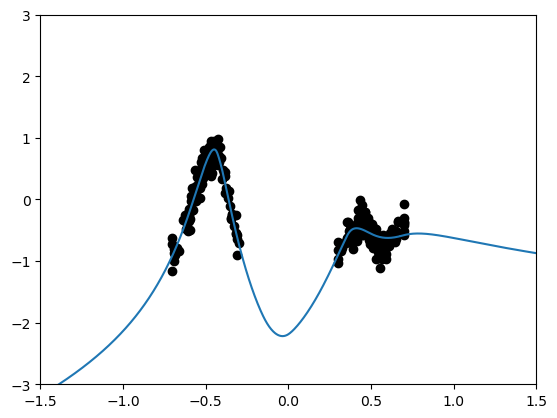

In [18]:
class train_cfg:
    NUM_EPOCHS = 1000
    BATCH_SIZE = 32
    LR = 3e-3
    WD = 0.
    VAL_FREQ = 100

class cfg:
    IN_FEATURES = 1
    HIDDEN_FEATURES = 64
    OUT_FEATURES = 1
    NUM_LAYERS = 4

# Create an instance of the MLP model
model = MLP(cfg())

# Train the model
trained_params = train(lambda rng: data_loader(rng, dataset, train_cfg.BATCH_SIZE), model, train_cfg)

# Visualize the model
viz_model(model, trained_params, dataset)

As can be seen above, the model has trained and makes good prediction. However, we don't know how well it predicts far from data, and we don't have any measure of the model's uncertainty. Next, we will modify the above loop to include a VBLL last layer.

Notice that the only required change in the model definition is changing out_layer in the model params to a VBLLRegression layer. This layer also takes parameters:
- REG_WEIGHT: the KL regularization strength. By default, this should be 1/(dataset size). This term primarily impacts the last layer _epistemic_ uncertainty.
- PRIOR_SCALE: the scale of the last layer prior. This also behaves as a regularization term, and controls last layer regularization strength.
- WISHART_SCALE: regularization strengthe for the noise covariance. This term impacts the estimated _aleatoric_ uncertainty.

In [19]:
class VBLLMLP(nn.Module):
    """
    A MLP with VBLL
    cfg: a config containing model parameters
    """

    cfg: any

    def setup(self):
        # define model layers
        self.in_layer = nn.Dense(features=self.cfg.HIDDEN_FEATURES)
        self.core = [nn.Dense(features=self.cfg.HIDDEN_FEATURES) for _ in range(self.cfg.NUM_LAYERS)]
        self.activations = [jax.nn.elu for _ in range(self.cfg.NUM_LAYERS)]
        self.out_layer = vbll.Regression_JAX(
            in_features=self.cfg.HIDDEN_FEATURES,
            out_features=self.cfg.OUT_FEATURES,
            regularization_weight=self.cfg.REG_WEIGHT,
            prior_scale=self.cfg.PRIOR_SCALE,
            wishart_scale=self.cfg.WISHART_SCALE
        )

    def __call__(self, x):
        x = self.in_layer(x)
        for layer, activation in zip(self.core, self.activations):
            x = activation(layer(x))
        x = self.out_layer(x)
        return x

In [20]:
def viz_vbll_model(model, params, dataset, stdevs=1.0, title=None):
    """Visualize VBLL model predictions, including predictive uncertainty."""
    X = jnp.linspace(-1.5, 1.5, 1000)[:, None]
    Xp = X.squeeze()

    @jax.jit
    def predict(params, x):
        return model.apply({'params': params}, x).predictive

    Y_pred = predict(params, X)
    Y_mean = Y_pred.mean.squeeze()
    Y_stdev = jnp.sqrt(jnp.diag(Y_pred.covariance)).squeeze()

    plt.plot(Xp, Y_mean)
    plt.fill_between(Xp, Y_mean - stdevs * Y_stdev, Y_mean + stdevs * Y_stdev, alpha=0.2, color='b')
    plt.fill_between(Xp, Y_mean - 2 * stdevs * Y_stdev, Y_mean + 2 * stdevs * Y_stdev, alpha=0.2, color='b')
    plt.scatter(dataset.X, dataset.Y, color='k')
    plt.axis([-1.5, 1.5, -2, 2])
    if title is not None:
        plt.title(title)
    plt.show()

def train_vbll(dataloader, model, train_cfg, verbose=True):
    """Train a VBLL model."""

    def create_train_state_vbll(rng, model, train_cfg):
        """Create and initialize the training state for VBLL."""
        params = model.init(rng, jnp.ones([1, model.cfg.IN_FEATURES]))['params']
        schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=train_cfg.LR,
            warmup_steps=50,
            decay_steps=train_cfg.NUM_EPOCHS,
            end_value=0.0,
        )
        tx = optax.chain(
            optax.clip_by_global_norm(train_cfg.CLIP_VAL),
            optax.adamw(learning_rate=schedule, weight_decay=train_cfg.WD)
        )
        return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

    @jax.jit
    def train_step_vbll(state, x, y):
        """Perform a single training step for VBLL."""
        def loss_fn(params):
            out = model.apply({'params': params}, x)
            return out.train_loss_fn(y)

        loss_value, grads = jax.value_and_grad(loss_fn)(state.params)
        state = state.apply_gradients(grads=grads)
        return state, loss_value

    rng = jax.random.PRNGKey(0)
    state = create_train_state_vbll(rng, model, train_cfg)

    for epoch in range(train_cfg.NUM_EPOCHS + 1):
        rng, data_rng = jax.random.split(rng)
        running_loss = 0

        for batch in dataloader(data_rng):
            x_batch, y_batch = batch
            state, loss = train_step_vbll(state, x_batch, y_batch)
            running_loss += loss

        if epoch % train_cfg.VAL_FREQ == 0 and verbose:
            avg_loss = running_loss / (len(dataset) // train_cfg.BATCH_SIZE)
            print(f'Epoch: {epoch:4d}, loss: {avg_loss:10.4f}')

    return state.params

class train_cfg:
    NUM_EPOCHS = 1000
    BATCH_SIZE = 32
    LR = 1e-3
    WD = 1e-4
    CLIP_VAL = 1.0
    VAL_FREQ = 100

class cfg:
    IN_FEATURES = 1
    HIDDEN_FEATURES = 64
    OUT_FEATURES = 1
    NUM_LAYERS = 4
    REG_WEIGHT = 1. / dataset.__len__()
    PARAM = 'dense'
    PRIOR_SCALE = 1.
    WISHART_SCALE = 0.01
    DOF = 1.0

vbll_model = VBLLMLP(cfg())
trained_params = train_vbll(lambda rng: data_loader(rng, dataset, train_cfg.BATCH_SIZE), vbll_model, train_cfg)
viz_vbll_model(vbll_model, trained_params, dataset)

AttributeError: module 'vbll' has no attribute 'Regression_JAX'

In [23]:
vbll.jax.Regression_JAX

AttributeError: module 'vbll' has no attribute 'jax'

In [1]:
import vbll

In [4]:
vbll.layers

<module 'vbll.layers' from '/Users/conor/Library/CloudStorage/OneDrive-QueenslandUniversityofTechnology/Documents/GitHub/vbll/vbll/layers/__init__.py'>

In [8]:
vbll.Regression_JAX

AttributeError: module 'vbll' has no attribute 'Regression_JAX'